In [1]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
import cv2
import numpy as np
import face_recognition
import os
from time import sleep
import sys
from facenet_pytorch import MTCNN

In [2]:
# Test for GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))


Running on device: cpu


In [26]:
mtcnn = MTCNN(
    image_size=160, margin=40, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device=device
)

In [16]:
np_frame = cv2.imread('/tmp/s3bucket/testdir/person1.png')
np_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)

In [42]:
image_dir = '/tmp/s3bucket/testdir/'

In [43]:
def crop_face_from_image(image_file):
    file_path = image_dir + image_file
    np_frame = cv2.imread(file_path)
    if np_frame is None:
        return None
    np_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)
    frame = Image.fromarray(np_frame)
    boxes, p = mtcnn.detect(frame)
    for i in range(len(p)):
        if p[i] is not None and p[i] > 0.9:
            print("face detected!!")
            face_crop = frame.crop(boxes[i])
            arr_img = np.array(face_crop)
            return arr_img
    return None

In [46]:
def calculate_embedding_from_image(np_image):
    encoding = face_recognition.face_encodings(np_image)
    if len(encoding) == 0:
        return None
    return encoding[0]

In [44]:
arr_image = crop_face_from_image('person1.png')

face detected!!


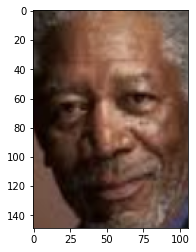

In [45]:
plt.imshow(arr_image)

In [47]:
encoding1 = calculate_embedding_from_image(arr_image)

In [49]:
image2 = crop_face_from_image('person2.png')

face detected!!


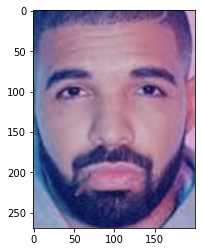

In [50]:
plt.imshow(image2)

In [51]:
encoding2 = calculate_embedding_from_image(image2)

In [53]:
ret = face_recognition.compare_faces([encoding1], encoding2)

In [55]:
ret[0]

False

In [57]:
def analyze_image(image, encoding, embedding_dict):
    for key, value in embedding_dict.items():
        enc = value[0]
        res = face_recognition.compare_faces([enc], encoding)
        if res[0]:
            print("A matching image found: {}, {}".format(key, image))
            value[1].append(image)
            return
    print("Adding a new image: {}".format(image))
    embedding_dict[image] = (encoding,[image])

In [60]:
person_list = ['person1.png','person2.png','person3.png','person4.png','person5.png','person6.png','person7.png','person8.png']

In [63]:
embedding_dict = {}
np_images = []

In [64]:
for p in person_list:
    np_image = crop_face_from_image(p)
    if np_image is None:
        print("problem with {}".format(p))
        continue
    encoding = calculate_embedding_from_image(np_image)
    if encoding is None:
        print("encoding problem with {}".format(p))
        del np_image
        continue
    np_images.append(np_image)
    analyze_image(p, encoding, embedding_dict)

face detected!!
Adding a new image: person1.png
face detected!!
Adding a new image: person2.png
face detected!!
Adding a new image: person3.png
face detected!!
Adding a new image: person4.png
face detected!!
encoding problem with person5.png
face detected!!
Adding a new image: person6.png
face detected!!
A matching image found: person6.png, person7.png
face detected!!
A matching image found: person6.png, person8.png


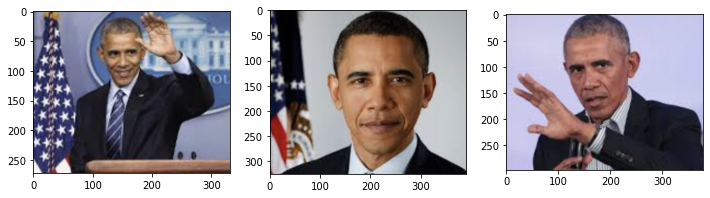

Do you know this person?


In [69]:
for key, value in embedding_dict.items():
    if len(value[1]) > 1:
        count = len(value[1])
        fig=plt.figure(figsize=(12, 12))
        columns = 3
        rows = int(np.ceil(count/columns))
        for i in range(0, count):
            image_path = image_dir + value[1][i]
            np_frame = cv2.imread(image_path)
            np_frame = cv2.cvtColor(np_frame, cv2.COLOR_RGB2BGR)       
            fig.add_subplot(rows, columns, i+1)
            plt.imshow(np_frame)
        plt.show()
        print("Do you know this person?")